# 載入套件

In [84]:
import numpy as np
import pandas as pd
import librosa
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score,f1_score
from pytorch_tabnet.metrics import Metric
from pytorch_tabnet.tab_model import TabNetClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold,KFold,RandomizedSearchCV
from sklearn.utils import class_weight
import torch
import random
from joblib import dump, load
import transformers
from transformers import AutoModelForAudioClassification,AutoFeatureExtractor


In [16]:
seed = 42
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True  
torch.backends.cudnn.benchmark = False
device = "cuda" if torch.cuda.is_available() else "cpu"

# 資料路徑設定

In [17]:
medical_file_name = "./data/training datalist.csv"
accoustic_folder="./data/training_voice_data/"

# 模型路徑

In [36]:
medical_model_path = "AI_CUP_medical_model.joblib"
with open("./accoustic_model_path.txt", "r") as file:
    accoustic_model_path = file.read().strip()
accoustic_model_path

'accoustic_model/checkpoint-1924'

# 載入訓練資料

In [37]:
# 讀取訓練資料集表單
source_df = pd.read_csv(medical_file_name)
print("source_df.shape :", source_df.shape)
print("source_df.columns :", source_df.columns)

source_df.shape : (1000, 28)
source_df.columns : Index(['ID', 'Sex', 'Age', 'Disease category', 'Narrow pitch range',
       'Decreased volume', 'Fatigue', 'Dryness', 'Lumping', 'heartburn',
       'Choking', 'Eye dryness', 'PND', 'Smoking', 'PPD', 'Drinking',
       'frequency', 'Diurnal pattern', 'Onset of dysphonia ', 'Noise at work',
       'Occupational vocal demand', 'Diabetes', 'Hypertension', 'CAD',
       'Head and Neck Cancer', 'Head injury', 'CVA',
       'Voice handicap index - 10'],
      dtype='object')


# 資料前處理

In [38]:
from sklearn.preprocessing import StandardScaler
def medical_data_proccessing(df):
    # 這邊要加入ID  用於轉換資料時對應
    medical_col = ['ID','Sex', 'Age', 'Narrow pitch range',
                'Decreased volume', 'Fatigue', 'Dryness', 'Lumping', 'heartburn',
                'Choking', 'Eye dryness', 'PND', 'Smoking', 'PPD', 'Drinking',
                'frequency', 'Diurnal pattern', 'Onset of dysphonia ', 'Noise at work',
                'Occupational vocal demand', 'Diabetes', 'Hypertension', 'CAD',
                'Head and Neck Cancer', 'Head injury', 'CVA',
                'Voice handicap index - 10', 'Disease category']
    
    df = df.loc[df['Disease category'].isin([1, 2, 3,4,5]), medical_col]

    # 將性別編碼0,1
    df['Sex'] = df['Sex'] - 1
    df['Disease category'] = df['Disease category']-1
    # 將空值填0
    df['PPD'] = df['PPD'].fillna(0)
    df['Voice handicap index - 10'] = df['Voice handicap index - 10'].fillna(0)

    # 正規化過大的數值
    standardScaler = StandardScaler()
    df[['Age','Voice handicap index - 10']] = standardScaler.fit_transform(df[['Age','Voice handicap index - 10']])

    return df

# 切分訓練與驗證資料
* 確保training data與testing data個類別的比例相同
* 將training data分為兩部分first half與second half，前者用在first stage 訓練，後者用在second stage訓練

In [39]:
training_df = pd.DataFrame()
test_df = pd.DataFrame()
for i in range(1,6):
    len_1=len(source_df[source_df['Disease category']==i])
    training_df = pd.concat([training_df,source_df[source_df['Disease category']==i].iloc[:int(len_1/6*5),:]])
    test_df = pd.concat([test_df,source_df[source_df['Disease category']==i].iloc[int(len_1/6*5):,:]])
print("training_df shape :", training_df.shape, ", test_df shape :", test_df.shape)

training_df shape : (831, 28) , test_df shape : (169, 28)


In [40]:
train_df_second_half = pd.DataFrame()
for i in range(1,6):
    len_1=len(training_df[training_df['Disease category']==i])
    train_df_second_half = pd.concat([train_df_second_half,training_df[training_df['Disease category']==i].iloc[int(len_1/2):,:]])
print("train_df_second_half shape :", train_df_second_half.shape)

train_df_second_half shape : (416, 28)


In [41]:
train_df_second_half['Disease category'].value_counts()

Disease category
1    223
2     92
3     70
4     18
5     13
Name: count, dtype: int64

In [42]:
training_df = train_df_second_half.sample(frac=1).reset_index(drop=True)
test_df = test_df.sample(frac=1).reset_index(drop=True)

In [43]:
training_df = medical_data_proccessing(training_df)

# 在dataframe中加入要訓練的音檔路徑
training_df['wav_path'] = training_df['ID'].map(lambda x :f"{accoustic_folder}{x}.wav")

print("Disease category in training_df :", training_df['Disease category'].unique())
print("training_df col :\n", training_df.columns)
print("training_df shape :", training_df.shape)

Disease category in training_df : [0 1 2 3 4]
training_df col :
 Index(['ID', 'Sex', 'Age', 'Narrow pitch range', 'Decreased volume', 'Fatigue',
       'Dryness', 'Lumping', 'heartburn', 'Choking', 'Eye dryness', 'PND',
       'Smoking', 'PPD', 'Drinking', 'frequency', 'Diurnal pattern',
       'Onset of dysphonia ', 'Noise at work', 'Occupational vocal demand',
       'Diabetes', 'Hypertension', 'CAD', 'Head and Neck Cancer',
       'Head injury', 'CVA', 'Voice handicap index - 10', 'Disease category',
       'wav_path'],
      dtype='object')
training_df shape : (416, 29)


In [44]:
test_df = medical_data_proccessing(test_df)

# 在dataframe中加入要測試的音檔路徑
test_df['wav_path'] = test_df['ID'].map(lambda x :f"{accoustic_folder}{x}.wav")

print("test_df columns :", test_df.columns)
print("test_df.shape :", test_df.shape)

test_df columns : Index(['ID', 'Sex', 'Age', 'Narrow pitch range', 'Decreased volume', 'Fatigue',
       'Dryness', 'Lumping', 'heartburn', 'Choking', 'Eye dryness', 'PND',
       'Smoking', 'PPD', 'Drinking', 'frequency', 'Diurnal pattern',
       'Onset of dysphonia ', 'Noise at work', 'Occupational vocal demand',
       'Diabetes', 'Hypertension', 'CAD', 'Head and Neck Cancer',
       'Head injury', 'CVA', 'Voice handicap index - 10', 'Disease category',
       'wav_path'],
      dtype='object')
test_df.shape : (169, 29)


## 準備第二階段模型的訓練資料

In [45]:
feature_extractor = AutoFeatureExtractor.from_pretrained(accoustic_model_path)
def preprocess_function(examples):
    audio_arrays = librosa.load(examples, sr=16000, offset=0)[0]
    inputs = feature_extractor(audio_arrays, sampling_rate=16000, return_tensors="pt")
    return inputs

In [46]:
def second_stage_dataproccessing(training_df, acoustic_model, medical_model):
    training_id = training_df['ID'].tolist()
    training_data = pd.DataFrame()
    for id in training_id:
        
        # 取病理資料
        medical_data = training_df[training_df['ID']==id].iloc[:, 1:27]
        df = pd.DataFrame(medical_data.copy()).reset_index(drop=True)

        # 透過聲學模型預測此病人的狀態
        inputs = preprocess_function(training_df[training_df['ID']==id]['wav_path'].values[0])
        logits = acoustic_model(**inputs).logits[0]
        pred = np.argmax(logits.detach().cpu().numpy())
        frame_pred_df = pd.DataFrame({"acoustic_pred":[pred]})
        df = pd.concat([df, frame_pred_df], axis=1)  

        # 透過病理模型預測此病人的狀態
        medical_pred = medical_model.predict(medical_data)
        df['medical_pred'] = medical_pred[0]
        
        # 訓練資料標記
        label = training_df[training_df['ID']==id]['Disease category'].values[0]
        df['class'] = label
        training_data = pd.concat([training_data, df])

    return training_data

In [47]:
medical_model = load(medical_model_path)
acoustic_model = AutoModelForAudioClassification.from_pretrained(accoustic_model_path)

In [48]:
training_data = second_stage_dataproccessing(training_df, acoustic_model, medical_model)
print("training_data.shape :", training_data.shape)

training_data.shape : (416, 29)


In [49]:
(training_data['acoustic_pred']==training_data['class']).sum()/len(training_data)

0.6610576923076923

In [50]:
(training_data['medical_pred']==training_data['class']).sum()/len(training_data)

0.6514423076923077

In [51]:
X_train = training_data.iloc[:, :-1]
y_train = training_data.iloc[:, -1:]
print("x_train.shape, y_train.shape :", X_train.shape, y_train.shape)
print("y_train.columns :", y_train.columns.tolist())

x_train.shape, y_train.shape : (416, 28) (416, 1)
y_train.columns : ['class']


In [52]:
test_data = second_stage_dataproccessing(test_df, acoustic_model, medical_model)

print("test_data.shape :", test_data.shape)

X_val = test_data.iloc[:, :-1]
y_val = test_data.iloc[:, -1:]
print("x_val.shape, y_val.shape :", X_val.shape, y_val.shape)
print("y_val.columns :", y_val.columns.tolist())

test_data.shape : (169, 29)
x_val.shape, y_val.shape : (169, 28) (169, 1)
y_val.columns : ['class']


# 訓練二階段模型

## 嘗試用XGBoost、SVM與tabnet做最後預測

In [53]:
def mean_recall(classifier,X,y):
    y_pred = classifier.predict(X)
    results_recall = recall_score(y, y_pred, average=None).mean()
    return results_recall

In [54]:
sample_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=y_train
)

In [55]:
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train.squeeze()), y=y_train.squeeze())
class_weights

array([0.37309417, 0.90434783, 1.18857143, 4.62222222, 6.4       ])

In [56]:
kfold = StratifiedKFold(random_state=42,shuffle=True)

## xgb

In [57]:
from sklearn.utils import class_weight
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,StratifiedKFold
import xgboost

xgb = xgboost.XGBClassifier()
param_test= {
 'n_estimators':[i*50 for i in range(1,6)],
    'max_depth':[1,2,3,4],
 'min_child_weight':range(3,7),
    'gamma':[i/10.0 for i in range(0,5)],
    "subsample": [i/10 for i in range(8,11)],
    "colsample_bytree":[i/10 for i in range(1,3)],
     'learning_rate':[i/20 for i in range(1,8)]
}
gs_xgb =GridSearchCV(xgb,param_test,cv = kfold,scoring=mean_recall,n_jobs=-1)
gs_xgb.fit(X_train, y_train,sample_weight = sample_weights)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_typ...
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.1, 0.2],
                         'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                         'learning_rate': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3,
                                           0.35],
                         'max_depth': [1, 2, 3, 4],
                         'min_child_weight': range(3, 7),
                         'n_estimators': [50, 100, 150, 200, 250],
                         'subsample': [0.8, 0.9, 1.0]},
             scoring=<function mean_recall at 0x7fd1483fa0d0>)

In [58]:
gs_xgb.best_score_,gs_xgb.best_params_

(0.5371583504215083,
 {'colsample_bytree': 0.2,
  'gamma': 0.2,
  'learning_rate': 0.1,
  'max_depth': 2,
  'min_child_weight': 5,
  'n_estimators': 100,
  'subsample': 0.8})

In [59]:
best_xgb = gs_xgb.best_estimator_

In [60]:
mean_recall(best_xgb,X_val,y_val)

0.5627992277992278

<Axes: >

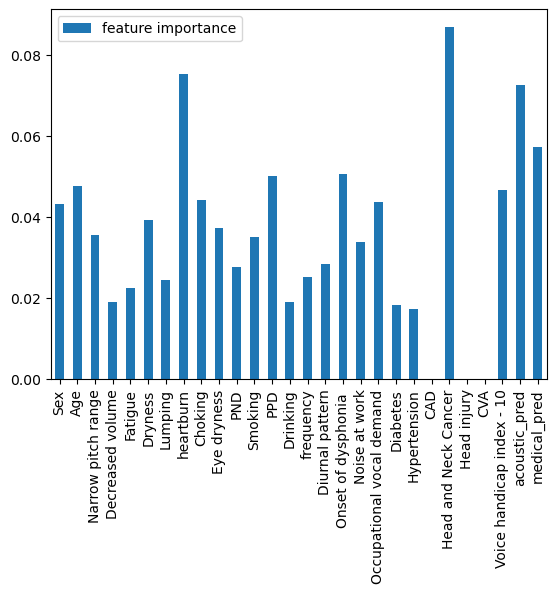

In [61]:
df = pd.DataFrame(best_xgb.feature_importances_,columns=["feature importance"])
df.index = best_xgb.feature_names_in_
df.plot(kind='bar')


## SVM

In [78]:
random_state = 42
svm = SVC(probability=True,random_state=random_state,class_weight=dict(enumerate(class_weights)))
kfold = StratifiedKFold(n_splits=5,shuffle=True)
svc_param_grid = {'kernel': ['rbf'], 
      'gamma': [ 0.001,0.01, 0.1, 1],
      'C': [1,50,100]}
gsSVMC = GridSearchCV(svm,param_grid = svc_param_grid, cv=kfold, scoring=mean_recall, n_jobs= -1, verbose = 1)
gsSVMC.fit(X_train,y_train.squeeze())

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=SVC(class_weight={0: 0.37309417040358744,
                                         1: 0.9043478260869565,
                                         2: 1.1885714285714286,
                                         3: 4.622222222222222, 4: 6.4},
                           probability=True, random_state=42),
             n_jobs=-1,
             param_grid={'C': [1, 50, 100], 'gamma': [0.001, 0.01, 0.1, 1],
                         'kernel': ['rbf']},
             scoring=<function mean_recall at 0x7fd1483fa0d0>, verbose=1)

In [79]:
gsSVMC.best_params_,gsSVMC.best_score_

({'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}, 0.43002886002886004)

In [80]:
mean_recall(gsSVMC,X_val,y_val)

0.6059566709566708

In [81]:
best_svm = gsSVMC.best_estimator_

## Tabnet

In [85]:
class Recall_M(Metric):
    def __init__(self):
        self._name = "recall"
        self._maximize = True

    def __call__(self, y_true, y_score):
        y_score = np.argmax(y_score,axis=1)
        results_recall = recall_score(y_true, y_score, average=None).mean()
        return results_recall
class F1(Metric):
    def __init__(self):
        self._name = "F1_score"
        self._maximize = True

    def __call__(self, y_true, y_score):
        y_score = np.argmax(y_score,axis=1)
        res = f1_score(y_true,y_score,average='macro')
        return res

In [86]:
import torch
if isinstance(X_val, pd.DataFrame):
    X_train, y_train = X_train.values, y_train.values
    X_val, y_val = X_val.values, y_val.values
tb_cls = TabNetClassifier(optimizer_fn=torch.optim.AdamW,
                       optimizer_params=dict(lr=1e-2),
                       scheduler_params={"step_size":40, "gamma":0.9},
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                       mask_type='entmax', # "sparsemax"
                       device_name = "cuda" if torch.cuda.is_available() else "cpu"   
                       )
res = tb_cls.fit(X_train,y_train.squeeze(),
               eval_set=[(X_train, y_train.squeeze()), (X_val, y_val.squeeze())],
               eval_name=['train', 'valid'],
               eval_metric=[Recall_M,"accuracy",F1],
                weights={0:class_weights[0],1:class_weights[1],2:class_weights[2],3:class_weights[3],4:class_weights[4]},
               max_epochs=1000 , patience=50,
               batch_size=4, drop_last=True)   

/home/samuel/.conda/envs/aicup/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.84789 | train_recall: 0.21077 | train_accuracy: 0.22837 | train_F1_score: 0.15748 | valid_recall: 0.25348 | valid_accuracy: 0.23077 | valid_F1_score: 0.17491 |  0:00:01s
epoch 1  | loss: 1.71058 | train_recall: 0.22598 | train_accuracy: 0.1899  | train_F1_score: 0.13974 | valid_recall: 0.26068 | valid_accuracy: 0.21893 | valid_F1_score: 0.19924 |  0:00:02s
epoch 2  | loss: 1.63892 | train_recall: 0.21533 | train_accuracy: 0.19471 | train_F1_score: 0.15885 | valid_recall: 0.15418 | valid_accuracy: 0.15976 | valid_F1_score: 0.1372  |  0:00:03s
epoch 3  | loss: 1.62113 | train_recall: 0.30119 | train_accuracy: 0.375   | train_F1_score: 0.2684  | valid_recall: 0.26408 | valid_accuracy: 0.36686 | valid_F1_score: 0.26597 |  0:00:04s
epoch 4  | loss: 1.60538 | train_recall: 0.26027 | train_accuracy: 0.29808 | train_F1_score: 0.18189 | valid_recall: 0.27461 | valid_accuracy: 0.32544 | valid_F1_score: 0.19105 |  0:00:05s
epoch 5  | loss: 1.58183 | train_recall: 0.24919 | trai

/home/samuel/.conda/envs/aicup/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [87]:
mean_recall(tb_cls,X_val,y_val)

0.4831960531960532

<Axes: >

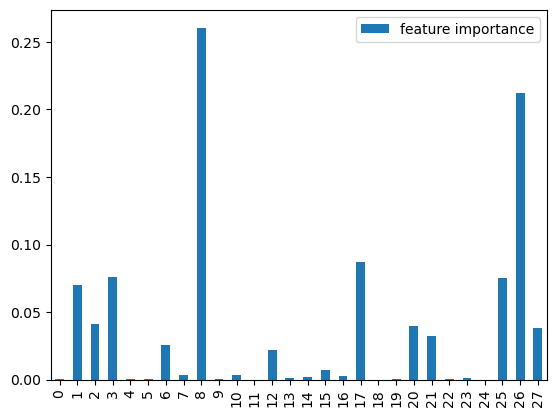

In [93]:
df = pd.DataFrame(tb_cls.feature_importances_,columns=["feature importance"])
df.plot(kind='bar')

In [ ]:
final_model = best_svm
dump(final_model, 'final_model.joblib')

## 訓練資料預測結果

Training UAR(Unweighted Average Recall) : 0.6307427634430949


/home/samuel/.conda/envs/aicup/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


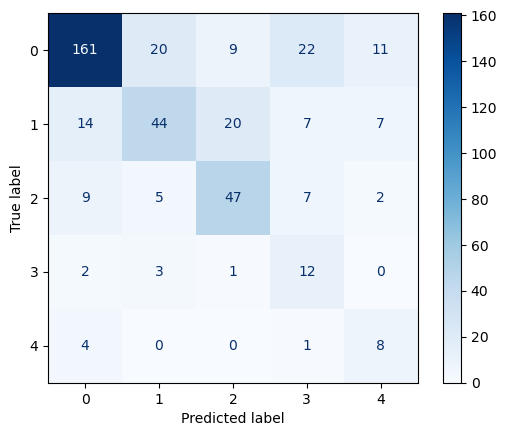

In [109]:
y_true = training_df['Disease category']
y_pred = final_model.predict(X_train)
training_id = training_df['ID'].tolist()
results_recall = recall_score(y_true.squeeze(), y_pred, average=None)
print("Training UAR(Unweighted Average Recall) :", results_recall.mean())

cm = confusion_matrix(y_true, y_pred)

ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred)).plot(cmap='Blues')

# 驗證資料測試結果

Test UAR(Unweighted Average Recall) : 0.6059566709566708


/home/samuel/.conda/envs/aicup/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


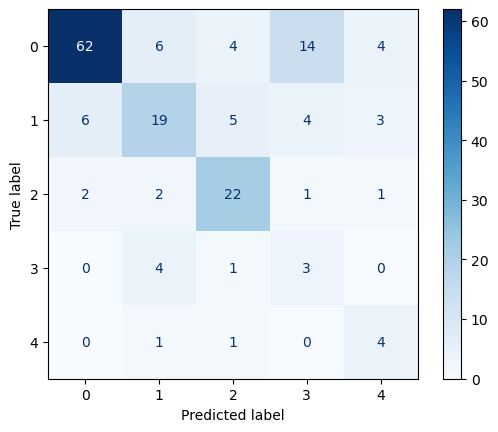

In [108]:
y_true = test_df['Disease category'] 

y_pred = final_model.predict(X_val)
training_id = test_df['ID'].tolist()

results_recall = recall_score(y_true.squeeze(), y_pred, average=None)
print("Test UAR(Unweighted Average Recall) :", results_recall.mean())

ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred)).plot(cmap='Blues')